In [2]:
import numpy as np
import pandas as pd
import os
import warnings
import librosa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from random import shuffle

from scipy.io import wavfile
import scipy.stats as scist

from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN
import umap

from nwb_utils import get_time_from_video, get_date_from_block, generate_recording_dtobj
from frequency_stats_utils import *
from pynwb import NWBHDF5IO
from pynwb.image import ImageSeries
from pynwb.epoch import TimeIntervals

In [2]:
# ----- LOAD UP ALL DATA INTO ONE BIG DATAFRAME -----

# -- Adjust paths to computer --
# use_computer = 'Ernest'
use_computer = 'Dorian'

match use_computer:
    case 'Dorian':
        nwbdir_path = 'M:\\scn2a-paper-GWJSNH\\ScnVoc_nwb'
        
    case 'Ernest':
        nwbdir_path = 'D:\\voc-WT_nwb'

usefield = 'freq_stats_filtered'

# -- Collect files --

allnwb = []
allnwb += [os.path.join(nwbdir_path,each) for each in os.listdir(nwbdir_path) if each.endswith('.nwb')]

nWT = 0
nHET = 0
    
# -- Loop over files and load up data --    
for i,fname in enumerate(allnwb):
    # open file
    io = NWBHDF5IO(os.path.join(nwbdir_path,fname), mode="r") # <-- open in write to append snippets?
    nwbfile = io.read()
    
    pathsplit = fname.split('\\')
    recstem = pathsplit[-1].strip('.nwb')
    
    print(recstem)
    
    statsdf = nwbfile.intervals[usefield].to_dataframe()
    
    # keep track of pair tag
    pair_tag = recstem.split('_')[0]
    
    # add metadata to big dataframe
    GT = nwbfile.subject.genotype
    
    if GT=='WT':
        nWT +=1
        pairnum = nWT
    else:
        nHET += 1
        pairnum = nHET

    # make big matching columns of pairtag, GT, days, expt
    nrcalls = statsdf.shape[0]
    massGT = [GT]*nrcalls
    massPairtag = [pair_tag]*nrcalls
    massPairnum = [pairnum]*nrcalls
    
    nrcols = statsdf.shape[1]
    
    # add columns
    statsdf.insert(nrcols, 'Pairtag', massPairtag, True)
    statsdf.insert(nrcols+1,'GT',massGT,True)
    statsdf.insert(nrcols+2,'pairnum',massPairnum,True)
    
    if i==0:
        bigdf = statsdf
    else:
        bigdf = pd.concat([bigdf, statsdf])
        
bws = bigdf.absMaxFreq-bigdf.absMinFreq
bigdf.insert(nrcols+3,'bandwidth',bws)

ScnVoc10_introductio
ScnVoc11_introductio
ScnVoc12_introductio
ScnVoc13_introductio
ScnVoc14_introductio
ScnVoc15_introductio
ScnVoc17_introductio
ScnVoc18_introductio
ScnVoc19_introductio
ScnVoc1_introductio
ScnVoc20_introductio
ScnVoc21_introductio
ScnVoc22_introductio
ScnVoc23_introductio
ScnVoc24_introductio
ScnVoc25_introductio
ScnVoc2_introductio
ScnVoc3_introductio
ScnVoc4_introductio
ScnVoc5_introductio
ScnVoc6_introductio
ScnVoc8_introductio
ScnVoc9_introductio


In [5]:
bigdf.to_csv('all_annotations_pairs1-25.csv')

In [3]:
# ----- LOAD DATA -----
data = pd.read_csv('all_annotations_pairs1-25.csv')

# ----- SET UP COLORS -----
acols = [[0.627451,   0.57254905, 0.37254903],
        [0.9607843,  0.7882353,  0.15294118],
        [0.34901962, 0.35686275, 0.49019608],
        [0.24705882, 0.30588236, 0.9607843 ]]

fcols = acols[0:2]
mcols = acols[2:]

ocolsd= [[0.15,0.15,0.15],
        [0.55,0.55,0.55]]

ocolsl = [[0.4,0.4,0.4],
          [0.8,0.8,0.8]]

fpal = sns.color_palette(fcols)
mpal = sns.color_palette(mcols)
apal = sns.color_palette(acols)
opald = sns.color_palette(ocolsd)
opall = sns.color_palette(ocolsl)


# set hue order
ho = ['WT','Het']

In [5]:
bigdf = data
bigdf.head()

,id,start_time,stop_time,callBool,duration,f0,numberFreqBands,numberPeaks,startFreq,endFreq,...,absMinFreq,absMaxFreq,sinuosity,timeToMaxPower,frequencyAtMaxPower,totalContourLength,Pairtag,GT,pairnum,bandwidth
0,0,3.740851,3.772061,1.0,0.031210,41503.90625,1.0,0.0,41438.747340,42120.127513,...,41438.747340,42120.127513,3.997139,0.016448,41438.747340,5.0,ScnVoc10,WT,1,681.380173
1,1,3.974819,3.990685,1.0,0.015866,41992.18750,1.0,0.0,41438.747340,42120.127513,...,41438.747340,42120.127513,3.016243,0.005648,42120.127513,4.0,ScnVoc10,WT,1,681.380173
2,2,72.325683,72.382509,1.0,0.056826,22949.21875,4.0,5.0,34633.228051,43046.094580,...,21936.499594,46958.051605,8.169094,0.016448,35587.548374,28.0,ScnVoc10,WT,1,25021.552011
3,3,73.862179,73.900829,1.0,0.038650,22460.93750,2.0,3.0,22176.314271,43046.094580,...,21348.247570,44959.545490,5.990807,0.016448,44959.545490,14.0,ScnVoc10,WT,1,23611.297920
4,4,83.740115,83.761101,1.0,0.020986,52246.09375,1.0,0.0,50671.567921,52923.980333,...,48251.983054,52923.980333,2.863733,0.016448,48251.983054,4.0,ScnVoc10,WT,1,4671.997279


In [6]:
# ----- PLOT SAVE PARAMETERS -----

saveplots = True
datestr  = '20250528'
outp = os.path.join('figures','2025May')

In [12]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette=sns.color_palette("Set2"),font_scale=1.0)

MannwhitneyuResult(statistic=109.0, pvalue=0.00890462720971815)


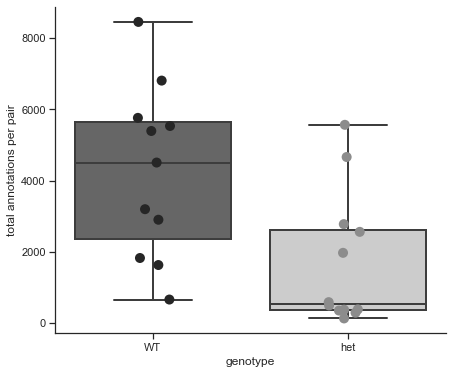

In [15]:
# ----- PLOT COUNTS BY GENOTYPE -----

# data handling
counttab = bigdf.groupby(['GT','Pairtag'])['start_time'].count()
counttab = counttab.reset_index().rename(columns={'start_time':'count'})

# stats
wtpoints = counttab[counttab.GT=='WT']['count']
hetpoints = counttab[counttab.GT=='het']['count']
mwu = scist.mannwhitneyu(wtpoints,hetpoints)
print(mwu)

# plotting
f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(data=counttab, x="GT", y="count",hue='GT',palette=opall,showfliers=False,linewidth=2)
sns.stripplot(counttab, x="GT", y="count", size=10, palette=opald,hue='GT')
ax.set(ylabel="total annotations per pair")
ax.set(xlabel='genotype')

if saveplots:
    plt.savefig(os.path.join(outp,f'{datestr}_annotations-per-pair_box-whisker.pdf'))

In [9]:
# ----- POWER ANALYSIS -----
from statsmodels.stats.power import TTestIndPower

# WTcounts = counttab[counttab.GT=='WT']
# hetcounts = counttab[counttab.GT=='het']

ttestres = scist.ttest_ind(wtpoints,hetpoints)

wtstd = np.std(wtpoints)
print(wtstd)
hetstd = np.std(hetpoints)
print(hetstd)

# calculate Glass's delta effect size as (mean(WT)-mean(het))/std(WT)
glassd = (np.mean(wtpoints)-np.mean(hetpoints))/wtstd
print(glassd)

# create an analysis of the correct form
analysis = TTestIndPower()

# solve for power
samplesize = analysis.solve_power(effect_size=glassd, alpha=0.05, nobs1=None, power=0.8, 
                                  alternative='two-sided')
print('n = ' + str(samplesize))

2296.95197602503
1782.0931669123127
1.115655045187647
n = 13.642249937945797


In [10]:
ttestres

Ttest_indResult(statistic=2.8691192962983467, pvalue=0.009184197627769609)

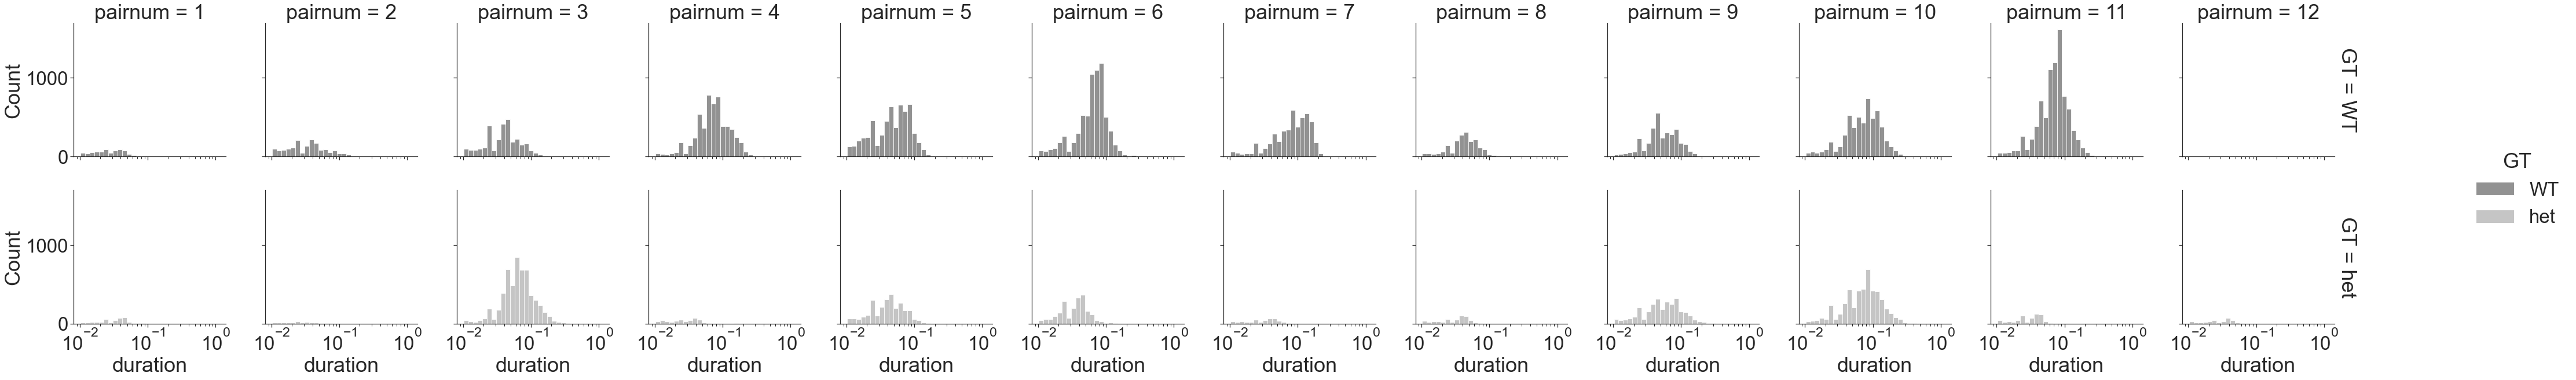

In [27]:
# ----- PLOT CALL DURATIONS -----

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette=opald,font_scale=3)

sns.displot(
    bigdf, x="duration", row="GT", col="pairnum",hue='GT',
    facet_kws=dict(margin_titles=True),log_scale = (True,False),bins=30,
)

if saveplots:
    plt.savefig(os.path.join(outp,f'{datestr}_durations-per-pair_count.png'))

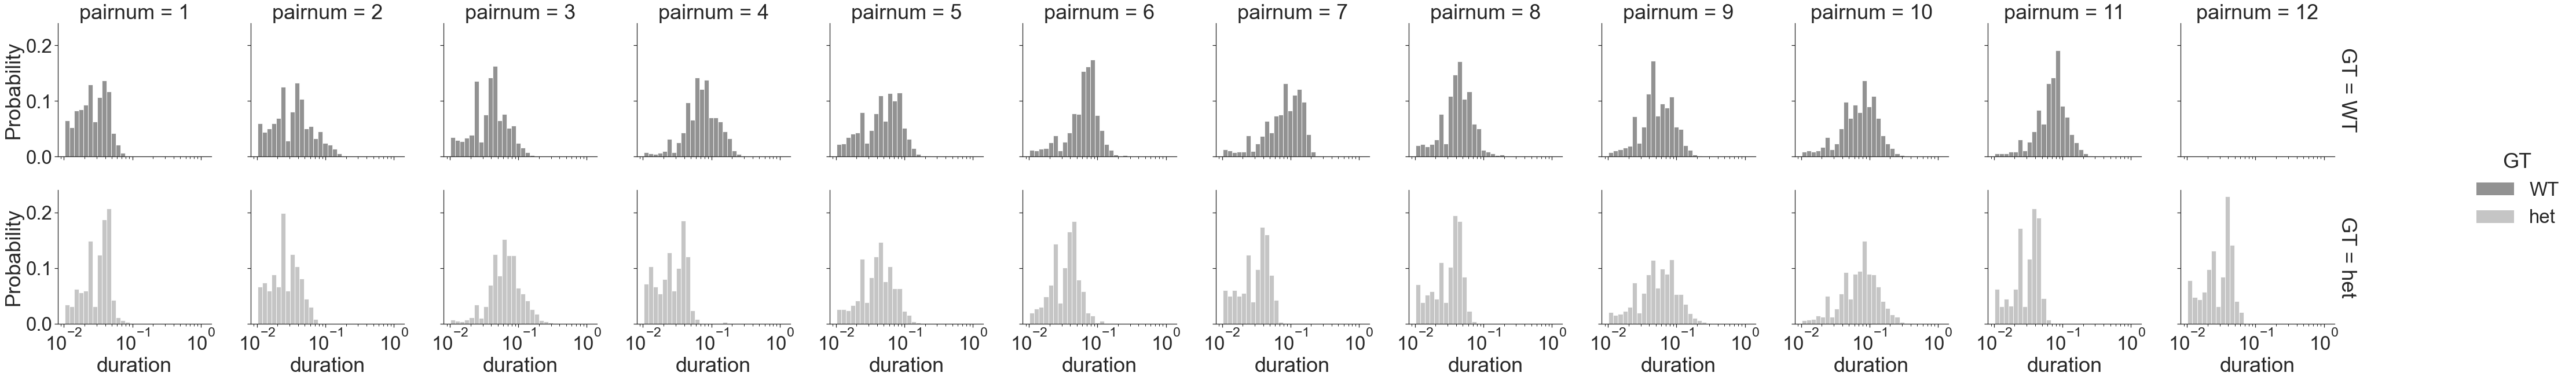

In [28]:
# ----- PLOT CALL DURATIONS PROBABILITY -----

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette=opald,font_scale=3)

sns.displot(
    bigdf, x="duration", row="GT", col="pairnum",hue='GT',stat='probability',
    facet_kws=dict(margin_titles=True),log_scale = (True,False),bins=30,common_norm=False,
)

if saveplots:
    plt.savefig(os.path.join(outp,f'{datestr}_durations-per-pair_probability.png'))

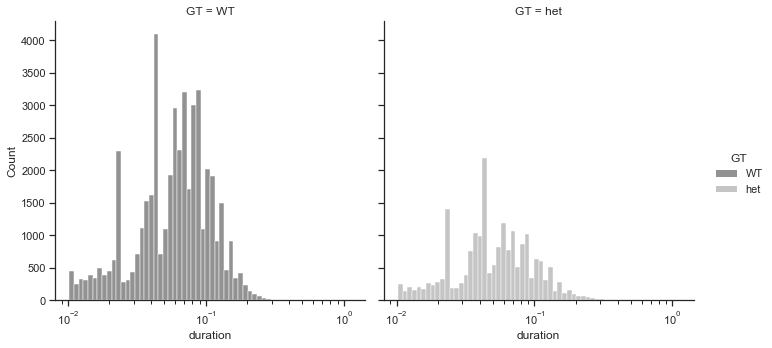

In [31]:
# ----- POPULATION DURATION DISTRIBUTION -----
sns.set_theme(style="ticks", rc=custom_params, palette=opald,font_scale=1)
# sns.histplot(data=bigdf,x='duration',log_scale=(True,False),hue='GT',palette=opald,bins=50)
sns.displot(bigdf,x='duration',col='GT',hue='GT',palette=opald,bins=60,log_scale=(True,False),)

if saveplots:
    plt.savefig(os.path.join(outp,f'{datestr}_durations-population_count.png'))

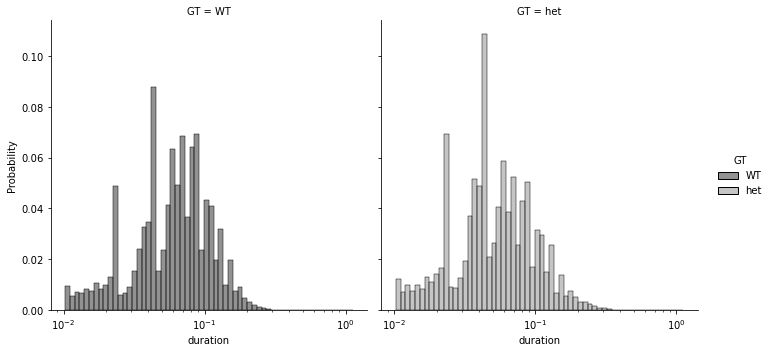

In [9]:
# ----- POPULATION DURATION DISTRIBUTION -----
sns.displot(bigdf,x='duration',col='GT',hue='GT',palette=opald,bins=60,log_scale=(True,False),stat='probability',
           common_norm=False,)

if saveplots:
    plt.savefig(os.path.join(outp,f'{datestr}_durations-population_probability.pdf'))

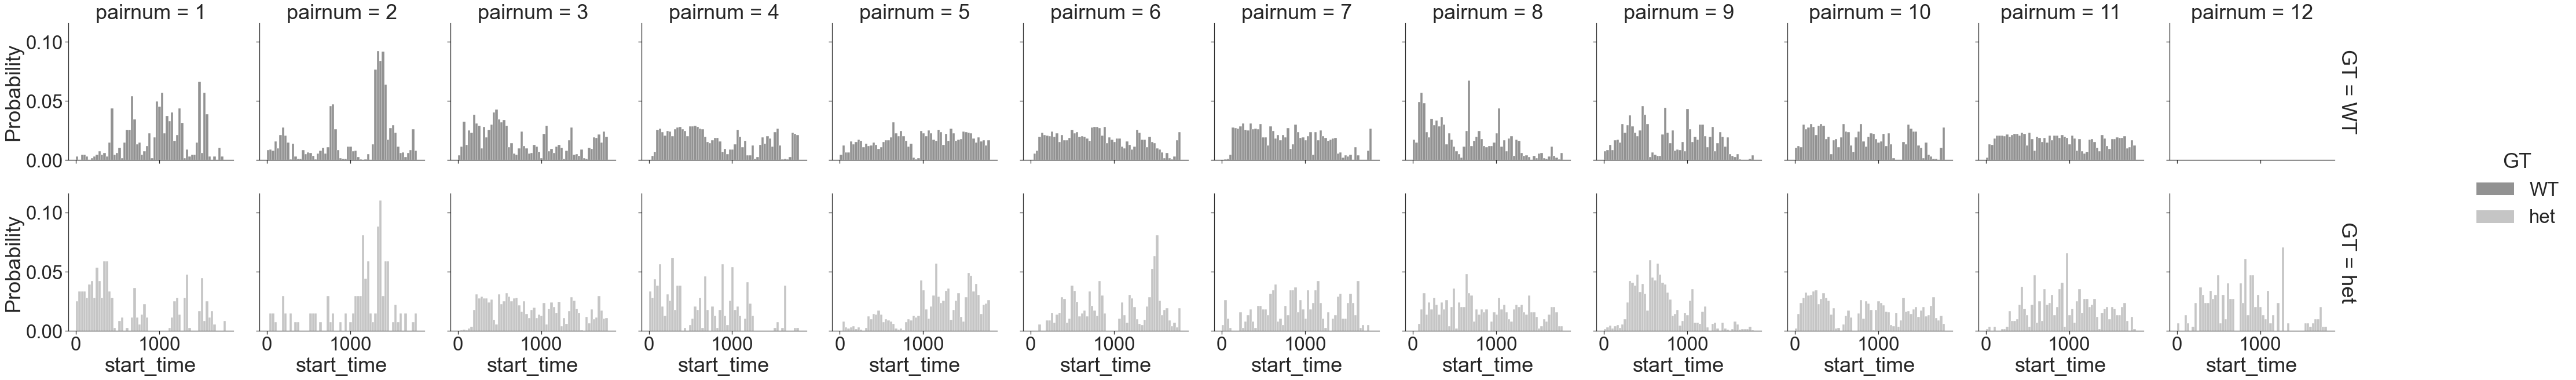

In [33]:
# ----- PLOT CALL TIMES DURING ASSAY -----

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette=opald,font_scale=3)

sns.displot(
    bigdf, x='start_time', row="GT", col="pairnum",hue='GT',stat='probability',
    facet_kws=dict(margin_titles=True),bins=60,common_norm=False,
)

if saveplots:
    plt.savefig(os.path.join(outp,f'{datestr}_callTimes_individuals_30sbin_probability.png'))

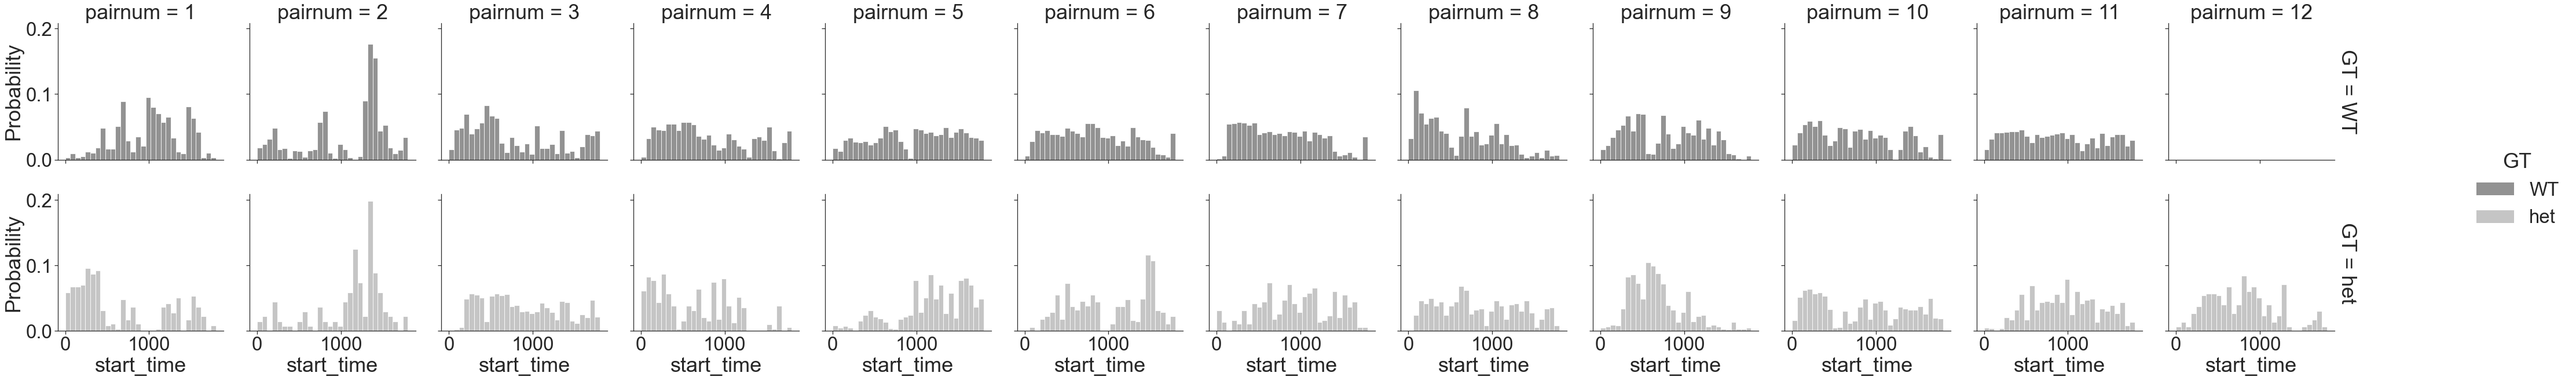

In [34]:
# ----- PLOT CALL TIMES DURING ASSAY -----

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette=opald,font_scale=3)

sns.displot(
    bigdf, x='start_time', row="GT", col="pairnum",hue='GT',stat='probability',
    facet_kws=dict(margin_titles=True),bins=30,common_norm=False,
)

if saveplots:
    plt.savefig(os.path.join(outp,f'{datestr}_callTimes_individuals_60sbin_probability.png'))

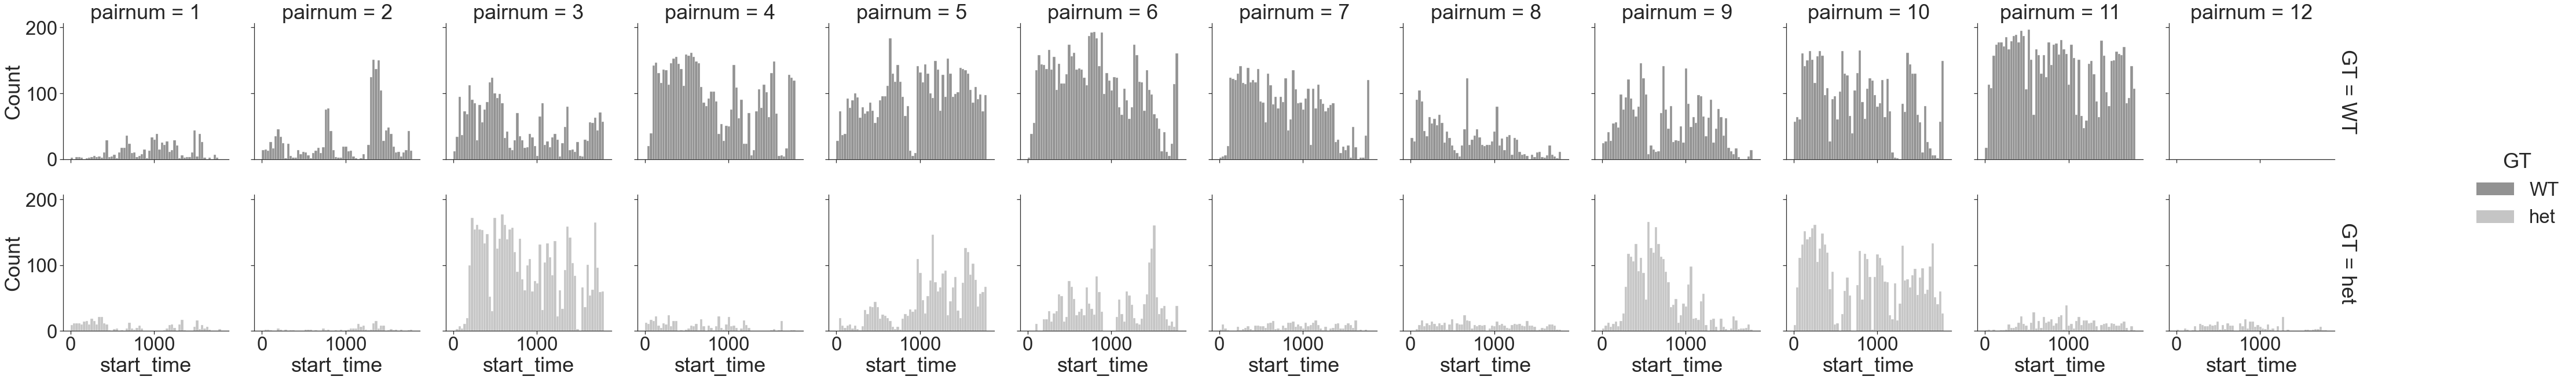

In [35]:
# ----- PLOT CALL TIMES DURING ASSAY -----

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette=opald,font_scale=3)

sns.displot(
    bigdf, x='start_time', row="GT", col="pairnum",hue='GT',stat='count',
    facet_kws=dict(margin_titles=True),bins=60,
)

if saveplots:
    plt.savefig(os.path.join(outp,f'{datestr}_callTimes_individuals_30sbin_count.png'))

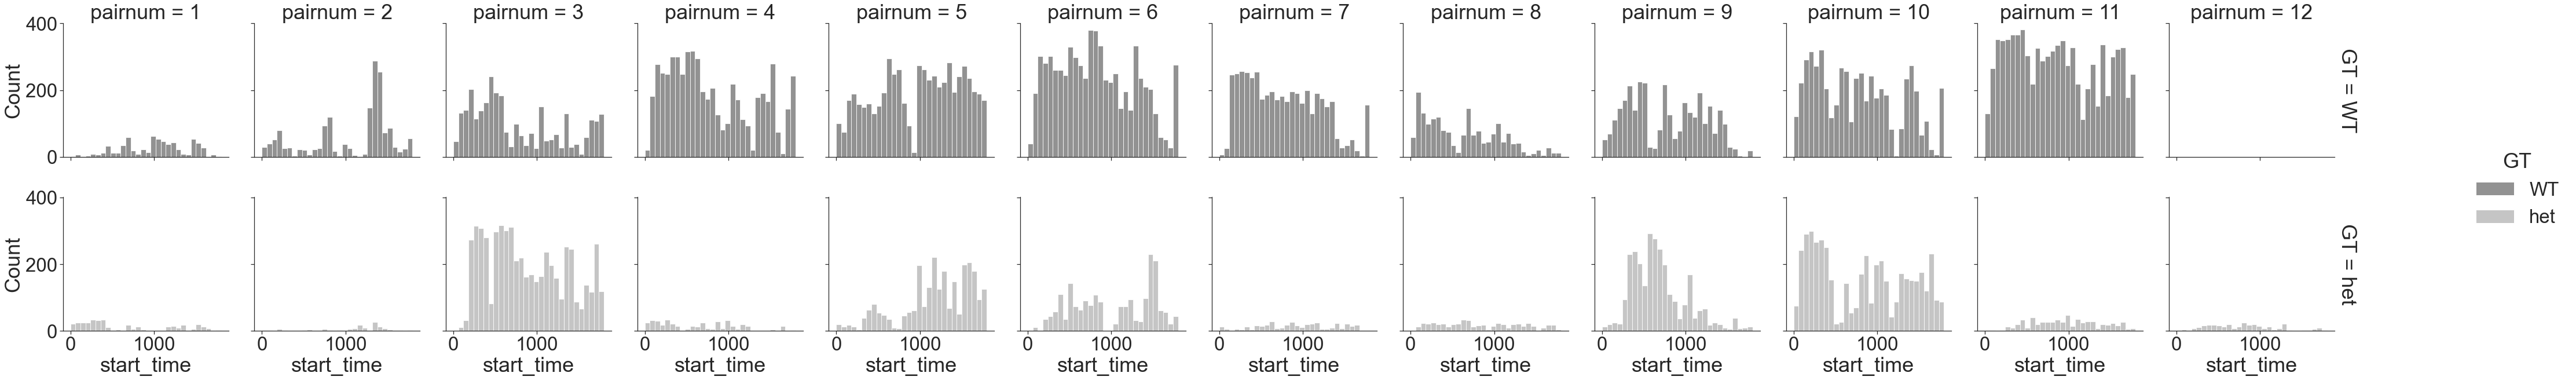

In [36]:
# ----- PLOT CALL TIMES DURING ASSAY -----

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette=opald,font_scale=3)

sns.displot(
    bigdf, x='start_time', row="GT", col="pairnum",hue='GT',stat='count',
    facet_kws=dict(margin_titles=True),bins=30,
)

if saveplots:
    plt.savefig(os.path.join(outp,f'{datestr}_callTimes_individuals_60sbin_probability.png'))

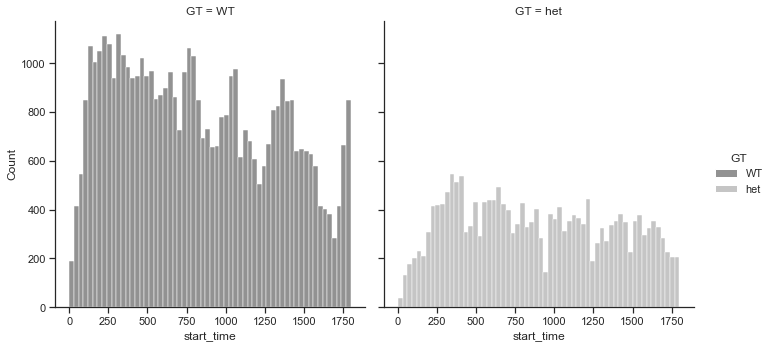

In [37]:
# ----- POPULATION ASSAY TIME DISTRIBUTION -----
sns.set_theme(style="ticks", rc=custom_params, palette=opald,font_scale=1)
sns.displot(bigdf,x='start_time',col='GT',hue='GT',palette=opald,bins=60)

if saveplots:
    plt.savefig(os.path.join(outp,f'{datestr}_callTimes_groups_30sbin_count.png'))

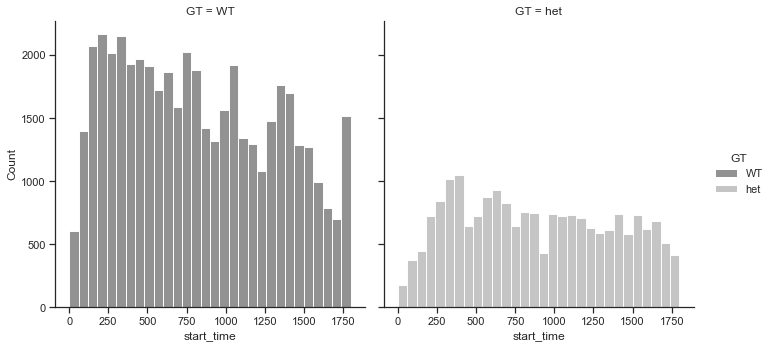

In [38]:
# ----- POPULATION ASSAY TIME DISTRIBUTION -----
sns.set_theme(style="ticks", rc=custom_params, palette=opald,font_scale=1)
sns.displot(bigdf,x='start_time',col='GT',hue='GT',palette=opald,bins=30)

if saveplots:
    plt.savefig(os.path.join(outp,f'{datestr}_callTimes_groups_60sbin_count.png'))

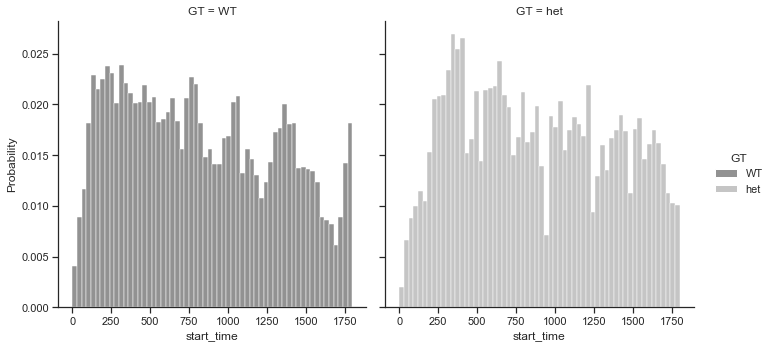

In [11]:
# ----- POPULATION ASSAY TIME DISTRIBUTION -----
custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(style="ticks", rc=custom_params, palette=opald,font_scale=1)
sns.displot(bigdf,x='start_time',col='GT',hue='GT',palette=opald,bins=60,stat='probability',common_norm=False)

if saveplots:
    plt.savefig(os.path.join(outp,f'{datestr}_callTimes_groups_30sbin_probability.pdf'))

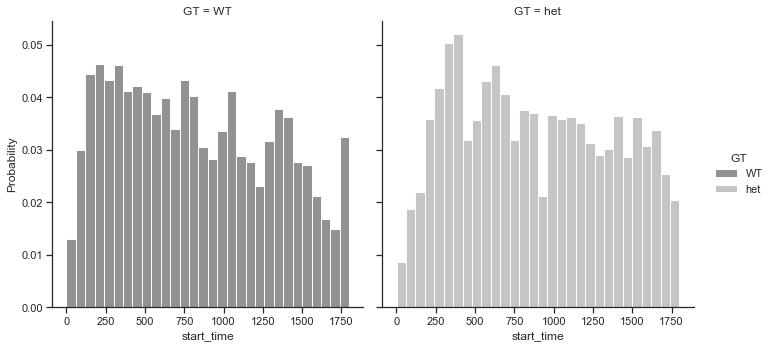

In [40]:
# ----- POPULATION ASSAY TIME DISTRIBUTION -----
sns.set_theme(style="ticks", rc=custom_params, palette=opald,font_scale=1)
sns.displot(bigdf,x='start_time',col='GT',hue='GT',palette=opald,bins=30,stat='probability',common_norm=False)

if saveplots:
    plt.savefig(os.path.join(outp,f'{datestr}_callTimes_groups_60sbin_probability.png'))

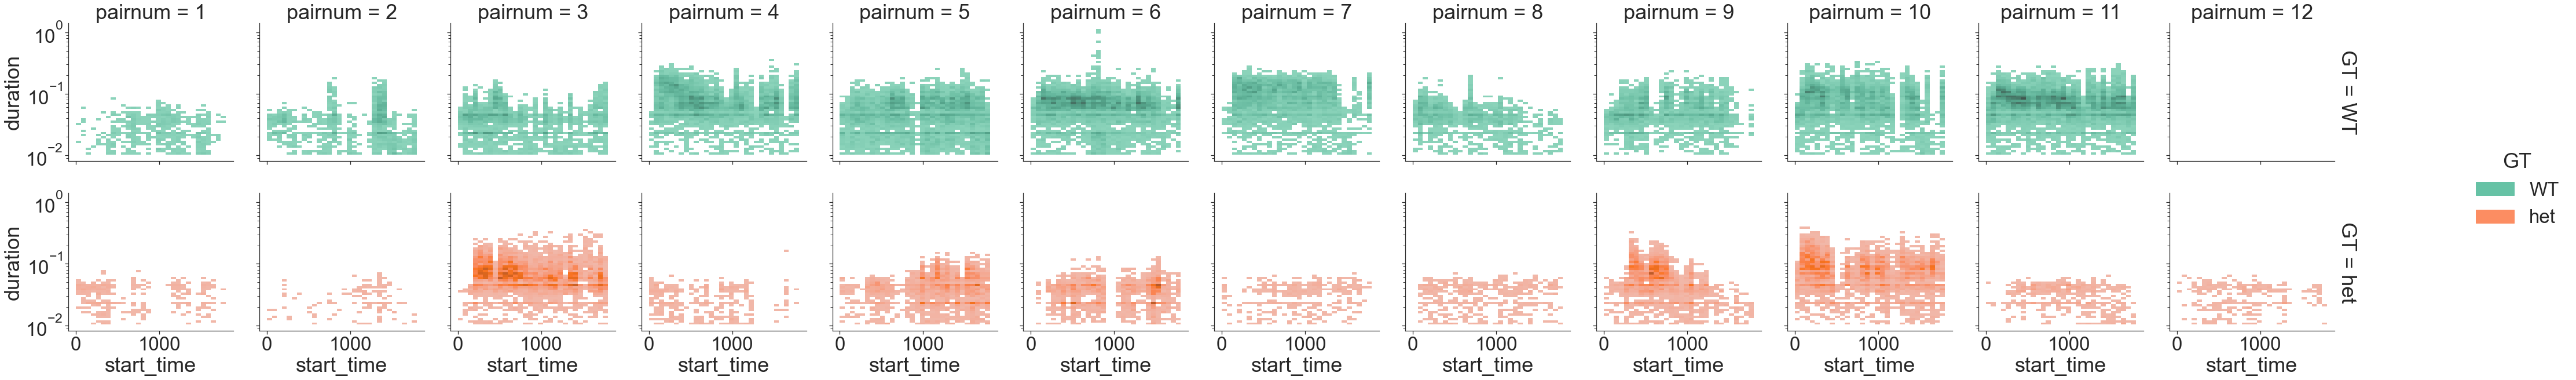

In [41]:
# --- Call time bivariate histograms ---

metric = 'duration'
nbins = 30

bw = (bigdf[metric].max()-bigdf[metric].min())/nbins

sns.set_theme(style="ticks", rc=custom_params, palette=sns.color_palette("Set2"),font_scale=3.0)

sns.displot(
    data=bigdf, x='start_time', y="duration", row="GT", col="pairnum",hue='GT',
    log_scale=(False, True), aspect=1,binwidth=(60,bw),facet_kws=dict(margin_titles=True),
)

if saveplots:
    plt.savefig(os.path.join(outp,f'{datestr}_callTimes_individuals_durVsCallTime_30sbin_count.png'))

In [ ]:
# ----- PLOT f0s -----

In [ ]:
# ----- PLOT NUMBER OF ENERGY BANDS -----